In [62]:
import numpy as np
import emcee
import matplotlib
import matplotlib.pyplot as plt
#%matplotlib inline
import pandas as pd
import corner
import corner
import time 
from scipy.stats import norm, laplace

from scipy.stats import anderson_ksamp, ks_2samp, shapiro
from scipy.optimize import curve_fit


In [63]:
# planet systems = Sys_{}_1e8.csv
def plot_hists( planet_systems,title=None):
    #try making more coherent plots
    ncol, nrow = 3,len(planet_systems)//3 +1
    #if len(planet_systems)%3 !=0:
    #    nrow+=1
    fig, axarr = plt.subplots(ncols=ncol,nrows=nrow)
    fig.set_size_inches((15, nrow*3))
    #axarr[0].histogram
    for jj , planet_sys in enumerate(planet_systems[:ncol*nrow]):
        #data =pd.read_csv("../../../mnt/stability_stuff/stabilitydataset/data/LongTimeScale/"+planet_sys, index_col = 0)
        data=pd.read_csv("../../csvs/Res_3_feats/" + planet_sys, index_col=0)
        
        #print planet_sys, data.shape

        data = data[data["t"]<1e8]
        data["logt"] = np.log10(data["t"])
        name = planet_sys.split("_")[2]
        # make guassian
        mean, sigma =  info[info["ID"]==int(name)][["Mean", "Sigma"]].values[0]

        x = np.linspace(mean - sigma*4, mean+sigma*4, 100)
        rv = norm(loc = mean, scale = sigma)
        axarr[jj//ncol, jj%ncol ].plot(x, rv.pdf(x), linewidth = 4, color = "black")
        #color = graph[-1].get_color()
        data.hist("logt",  ax = axarr[jj//ncol, jj%ncol],  label = name + " Mean - " +str("{0:.3f}".format(mean)) + " Sigma - "+ str("{0:.3f}".format(sigma)), alpha = 0.7, normed = 1, color = "purple", edgecolor = "black", bins = 20)
        #create gaussian on top 
        axarr[jj//ncol, jj%ncol ].set_title(name + r': $\mu$=' +str("{0:.3f}".format(mean)) + r': $\sigma$='+ str("{0:.3f}".format(sigma)))
    plt.show()
    if title == None:
        plt.close(fig)
    else:
        fig.savefig("../Figures/MCMCFigures/"+title, bbox_extent = "tight")
    #plt.close(fig)

In [64]:
np.random.seed(0)
#First let's create a gaussian data

#file_path = "../../../mnt/stability_stuff/stabilitydataset/data/LongTimeScale/"
file_path = "../../csvs/Res_3_feats/"
planet_systems = np.loadtxt(file_path+"order.txt", dtype = str)
#print planet_systems

# Then, define the probability distribution that you would like to sample.
def lnprob(p, vec):
    diff = vec-p[0]
    N = len(vec)
    #probs = 
    if p[1] <=0:
        return -np.inf#0
    try:
        probs = -0.5 * N * np.log(2. * np.pi) - N/2. * np.log(np.abs(p[1])**2) - 0.5 \
                                    * np.sum(( (vec - p[0]) / p[1] ) ** 2)
    except:
        probs = 0.00
    return probs
       
def log_prob_normed(mu, sigma, info):
    prob = -np.log(2*np.pi)/2. - np.log(sigma**2.)/2.-(1./(sigma**2.)/2./info.shape[0])*np.nansum((info-mu)**2.)
    #print 
    return prob
                                    
print planet_systems.shape

(317,)


In [65]:
np.random.seed(0)

#the delta times
delta_times = np.zeros((planet_systems.shape[0],3))

for jj, planet_sys in enumerate(planet_systems):
    try:
        times = pd.read_csv(file_path + planet_sys)
        delta_times[jj, 1:] = times["t"].values[:2]
        sys_id = planet_sys.split("_")[2]
        delta_times[jj, 0] = sys_id
    except:
        print "Did not work for {0}".format(planet_sys)
    
print(delta_times[:5, :])

[[0.00000000e+00 5.33062797e+03 9.37784115e+03]
 [1.00000000e+02 6.99705544e+04 6.97031351e+04]
 [1.01000000e+02 6.51055279e+05 5.06697334e+05]
 [1.02000000e+02 1.19833646e+07 1.38947086e+06]
 [1.03000000e+02 9.48782716e+02 4.00914304e+03]]


In [66]:
deltatimes=pd.DataFrame(delta_times, columns=["ID","t", "t_shadow"])
deltatimes= deltatimes.sort_values("ID")
print(deltatimes.shape)
deltatimes.tail()

(317, 3)


,ID,t,t_shadow
245,391.0,2.815414e+04,5.142078e+04
246,393.0,7.103793e+05,3.221912e+05
247,394.0,2.527237e+06,3.198412e+06
249,395.0,8.670889e+03,7.556106e+03
250,399.0,2.319745e+06,3.153388e+06


In [67]:
#deltatimes.to_csv(file_path + "/deltatimes.csv", index=False)

In [68]:
# trim by same criteria to see which are left
trimmed = deltatimes[(deltatimes["t"]<1e7) & (deltatimes["t"]>1e4)
                    & (deltatimes["t_shadow"]<1e7)& (deltatimes["t_shadow"]>1e4)]
trimmed.shape

(184, 3)

In [69]:
nwalkers = 20
ndim = 2
iterations = 1000

#store all the mean and  sigma in one large array, and then plot it all at the very end,
#since there are 48 systems, and 20*1000 samples per system, the final data array will be 960 000 long.
sample_size = nwalkers*iterations*planet_systems.shape[0]
all_walker_samples=np.zeros((int(sample_size), 4)) # add an extra clumn for the system index, and one for iteration number in for loop 
#mean_samples = np.zeros()
values = np.zeros((planet_systems.shape[0], 7), dtype=str)
covariences = np.zeros((planet_systems.shape[0], ndim, ndim))

In [70]:
planet_systems.shape
trimmed.shape
trimmed_ids = trimmed["ID"].values

In [10]:
info = pd.DataFrame(values, columns=["ID", "Probability", "Mean", "Sigma", "Mean_Error", "Sigma_Error", "Determinant"])
info.head()

for jj, planet_sys in enumerate(planet_systems):

    np.random.seed(jj)
    data =pd.read_csv(file_path+planet_sys, index_col = 0)
    data = data[data["t"]<1e8]
    #print data.shape
    data = np.log10(data["t"].values)
    sys_name = planet_sys.split("_")[2]
    print sys_name

    # Choose an initial set of positions for the walkers.
    p0 = [np.random.rand(ndim) for i in xrange(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[data], a=5)
    
    # Run 200 steps as a burn-in.
    #print "Burning in ..."
    pos, prob, state = sampler.run_mcmc(p0, 200)

    # Reset the chain to remove the burn-in samples.
    sampler.reset()
    
    print "Running MCMC ...",
    start = time.time()
    pos, prob, state = sampler.run_mcmc(pos, iterations, rstate0=jj)
    end = time.time()
    print "Done at ...", (end - start), "seconds." 
    #af = sampler.acceptance_fraction
    #print "Mean acceptance fraction:", np.mean(af)
    

    #Determine the best mean and sigma
    maxprob_indice = np.argmax(prob)
    mean_fit, sigma_fit = pos[maxprob_indice]
    sigma_fit = np.abs(sigma_fit)
    #print "Estimated parameters: mean, sigma = %f, %f" % (mean_fit, sigma_fit)
    mean_samples = sampler.flatchain[:,0]
    sigma_samples = sampler.flatchain[:,1]
    mean_std = mean_samples.std()
    sigma_std =np.std(np.abs(sigma_samples) )
    covarience = np.cov([mean_samples, sigma_samples])
    print covarience
    determinant = np.linalg.det(covarience)
    print determinant
    covariences[jj, :, :] = covarience

    
    
    ##PLOT CORNER PLOT
    probability = -np.log(2*np.pi)/2. - np.log(sigma_fit**2.)/2.-(1./(sigma_fit**2.)/2./info.shape[0])*np.nansum((data-mean_fit)**2.)
    samples = sampler.chain[:, :, :].reshape((-1, ndim))
    

       
    #SAVE INFO OF INTEREST
    if np.exp(probability)>1:
        info.loc[jj] = [sys_name]+[np.inf]+[mean_fit, sigma_fit] + [np.inf]*3

    else:
        info.loc[jj] = [sys_name, np.exp(probability), mean_fit, sigma_fit, mean_std, sigma_std, determinant]
    print sys_name , probability, np.exp(probability),"\n"
    
info.head()

0
Running MCMC ... Done at ... 0.764147996902 seconds.
[[ 2.79152307e-04 -4.36702743e-07]
 [-4.36702743e-07  1.51740564e-04]]
4.235853790100361e-08
0 -0.7419011693064684 0.47620770289392733 

100
Running MCMC ... Done at ... 0.740942001343 seconds.
[[ 6.46853865e-06 -1.36847097e-07]
 [-1.36847097e-07  3.38800463e-06]]
2.189671180609409e-11
100 1.1600455954582392 3.1900787259015613 

101
Running MCMC ... Done at ... 0.754605054855 seconds.
[[ 6.16356414e-05 -1.73608239e-06]
 [-1.73608239e-06  3.01130360e-05]]
1.8530223090169966e-09
101 0.0382838621835041 1.039026131247604 

102
Running MCMC ... Done at ... 0.742779970169 seconds.
[[ 8.65442508e-04 -1.20274548e-05]
 [-1.20274548e-05  4.57493981e-04]]
3.957900789137826e-07
102 -1.3029774718980294 0.2717215441242081 

103
Running MCMC ... Done at ... 0.751457929611 seconds.
[[ 2.05668401e-04 -4.91208933e-06]
 [-4.91208933e-06  1.00072140e-04]]
2.0557548447395103e-08
103 -0.5487843810043094 0.5776515879902221 

104
Running MCMC ... Done at 

,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant
0,0,0.476208,3.79507,0.37465,0.0167074,0.012318,4.23585e-08
1,100,inf,4.88955,0.0570529,inf,inf,inf
2,101,inf,5.86663,0.173948,inf,inf,inf
3,102,0.271722,6.01995,0.670632,0.0294177,0.0213886,3.9579e-07
4,103,0.577652,3.8656,0.321954,0.0143408,0.0100034,2.05575e-08


In [ ]:
# save the plot
info = info.astype("float64")
info = info.sort_values("ID")
info.to_csv(file_path + "Gaussian_Fits_{0}.csv".format(info.shape[0]),index=False)

In [71]:
info = pd.read_csv(file_path + "Gaussian_Fits_317.csv")
info.tail()

,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant
312,391.0,0.380109,4.832709,0.479577,0.021807,0.015415,1.130073e-07
313,393.0,0.181957,5.364817,1.022106,0.046608,0.033712,2.467449e-06
314,394.0,0.598461,6.614040,0.297937,0.013410,0.009552,1.640262e-08
315,395.0,0.409190,4.146248,0.439739,0.019946,0.013836,7.615377e-08
316,399.0,0.502488,6.190145,0.358946,0.016343,0.011388,3.460652e-08


In [72]:
trimmed_ids = trimmed["ID"].values
print trimmed_ids[:4], type(trimmed_ids[0]), type(info.loc[0]["ID"])
#trim info to match systems in trimmed
trimmed_info = info.loc[ info["ID"].isin(trimmed_ids) ]
print trimmed_info.shape

[3. 4. 5. 8.] <type 'numpy.float64'> <type 'numpy.float64'>
(184, 7)


In [73]:
trimmed_info.tail()

,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant
311,388.0,0.643354,6.883259,0.283976,0.012652,0.009407,1.416047e-08
312,391.0,0.380109,4.832709,0.479577,0.021807,0.015415,1.130073e-07
313,393.0,0.181957,5.364817,1.022106,0.046608,0.033712,2.467449e-06
314,394.0,0.598461,6.614040,0.297937,0.013410,0.009552,1.640262e-08
316,399.0,0.502488,6.190145,0.358946,0.016343,0.011388,3.460652e-08


In [74]:
#print type(planet_systems)
trimmed_systems = [x for x in planet_systems if int(x.split("_")[2]) in trimmed_ids ]
print trimmed_ids[:4]
print trimmed_systems[:4]
print np.where(3 ==trimmed["ID"])
trimmed_systems[:9]
print trimmed.shape

[3. 4. 5. 8.]
['Res_sys_100_500.csv', 'Res_sys_101_500.csv', 'Res_sys_108_500.csv', 'Res_sys_109_500.csv']
(array([0]),)
(184, 3)


In [15]:
#do tests for only valid systems within the instability time range cuts

sig_levels_and = np.zeros(len(trimmed))
sig_levels_kstest = np.zeros(len(trimmed))
sig_levels_shapiro = np.zeros(len(trimmed))
ids = np.zeros(len(trimmed))

for jj, planet_sys in enumerate(trimmed_systems):

    np.random.seed(jj)
    data =pd.read_csv(file_path +planet_sys, index_col = 0)
    data = data[data["t"]<1e8]
    data = np.log10(data["t"].values)
    #plt.hist(data)
    #plt.show()
    # id
    sys_name = float(planet_sys.split("_")[2])
    ids[jj] = sys_name
    index = np.where(sys_name==trimmed_info["ID"].values)[0][0]
    #print index, sys_name
    
    print(trimmed_info.iloc[index])
    # normal we want to match
    test = np.random.normal(loc=trimmed_info.iloc[index]["Mean"], scale=trimmed_info.iloc[index]["Sigma"], size = data.shape[0])
    #plt.hist(test)
    #plt.show()
    # anderson stats
    try:
        statistic, crit_val, sig_level =  anderson_ksamp([data, test])
    except:
        statistic, crit_val, sig_level = 0,0,0
    print sys_name
    print "And",  statistic,  crit_val, sig_level
    sig_levels_and[jj] = sig_level
    # sig level should be as low as possible, means it is rejected at anything higher
    # An approximate significance level at which the null hypothesis for the provided samples can be rejected.
    
    #ks test
    try:
        statistic, p_val = ks_2samp(data, test)
    except:
        statistic, p_val = 0,0
    sig_levels_kstest[jj] = p_val
    print "KS", statistic, p_val#, 
    
    #shapiro   
    #data  = norm.rvs(loc=1, scale=1, size=100)
    try:
        statistic, p_val = shapiro(data)
    except:
        statistic, p_val = 0,0
    sig_levels_shapiro[jj] = p_val
    print "SH", statistic, p_val
    #break

ID             100.000000
Probability           inf
Mean             4.889554
Sigma            0.057053
Mean_Error            inf
Sigma_Error           inf
Determinant           inf
Name: 100, dtype: float64
100.0
And 13.404614137511574 [0.325 1.226 1.961 2.718 3.752] 2.8831135466e-05
KS 0.146 3.9599420605401194e-05
SH 0.809592425823 7.67878230661e-24
ID             101.000000
Probability           inf
Mean             5.866634
Sigma            0.173948
Mean_Error            inf
Sigma_Error           inf
Determinant           inf
Name: 101, dtype: float64
101.0
And 2.4215553057422534 [0.325 1.226 1.961 2.718 3.752] 0.0325215279341
KS 0.09799999999999998 0.015202766669802529
SH 0.972015857697 3.52677744786e-08
ID             1.080000e+02
Probability    4.966994e-01
Mean           6.582686e+00
Sigma          3.624335e-01
Mean_Error     1.586039e-02
Sigma_Error    1.187837e-02
Determinant    3.549605e-08
Name: 108, dtype: float64
108.0
And -0.19649329556915068 [0.325 1.226 1.961 2.718 3.7

/home/naireen/anaconda2/lib/python2.7/site-packages/scipy/stats/morestats.py:1694: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


162.0
And 2.1597428352800665 [0.325 1.226 1.961 2.718 3.752] 0.0414260678989
KS 0.062000000000000055 0.2828891626185364
SH 0.937252998352 1.1435963938e-13
ID             1.650000e+02
Probability    5.856964e-01
Mean           4.496850e+00
Sigma          3.107233e-01
Mean_Error     1.416388e-02
Sigma_Error    9.876852e-03
Determinant    1.954538e-08
Name: 165, dtype: float64
165.0
And 39.285921707450704 [0.325 1.226 1.961 2.718 3.752] 0.0560483299667
KS 0.242 2.3931915252947646e-13
SH 0.656844377518 1.75666665719e-30
ID             1.660000e+02
Probability    4.986351e-01
Mean           4.621490e+00
Sigma          3.638392e-01
Mean_Error     1.623878e-02
Sigma_Error    1.158093e-02
Determinant    3.530899e-08
Name: 166, dtype: float64
166.0
And 35.4609434263998 [0.325 1.226 1.961 2.718 3.752] 0.00216632436949
KS 0.23399999999999999 1.6565575957239805e-12
SH 0.723914384842 6.2667569645e-28
ID             1.670000e+02
Probability    5.670301e-01
Mean           5.902034e+00
Sigma          

/home/naireen/anaconda2/lib/python2.7/site-packages/scipy/stats/morestats.py:1323: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


326.0
And 0.27535287560776106 [0.325 1.226 1.961 2.718 3.752] 0.261925556564
KS 0.057999999999999996 0.35990286596479987
SH 0.998349666595 0.921418964863
ID             3.270000e+02
Probability    8.780559e-01
Mean           4.730257e+00
Sigma          2.051022e-01
Mean_Error     9.337160e-03
Sigma_Error    6.744854e-03
Determinant    3.966499e-09
Name: 277, dtype: float64
327.0
And 1.9523901185702934 [0.325 1.226 1.961 2.718 3.752] 0.050301705874
KS 0.07600000000000007 0.1062917718094219
SH 0.96986156702 1.287839968e-08
ID             3.280000e+02
Probability    3.238225e-01
Mean           5.708192e+00
Sigma          5.632372e-01
Mean_Error     2.477074e-02
Sigma_Error    1.757723e-02
Determinant    1.895901e-07
Name: 278, dtype: float64
328.0
And 5.5356609572702835 [0.325 1.226 1.961 2.718 3.752] 0.00238521206728
KS 0.1 0.012432141728521395
SH 0.907324314117 6.79266094475e-17
ID             3.310000e+02
Probability    3.445302e-01
Mean           5.705517e+00
Sigma          5.230620e-

In [16]:
scores = np.vstack([ ids, sig_levels_and, sig_levels_kstest, sig_levels_shapiro])
print scores.shape
scores = pd.DataFrame(scores.T, columns=["ID", "Anderson_P", "KS_P", "ShapiroW"] )
scores.head()

(4, 184)


,ID,Anderson_P,KS_P,ShapiroW
0,100.0,0.000029,0.000040,7.678782e-24
1,101.0,0.032522,0.015203,3.526777e-08
2,108.0,0.427500,0.601915,5.864905e-06
3,109.0,0.540082,0.498083,3.596655e-06
4,113.0,0.026401,0.046678,7.397713e-13


In [17]:
scores.to_csv(file_path + "res_signficance_scores.csv",index=False)

      ID  Anderson_P      KS_P      ShapiroW
0  100.0    0.000029  0.000040  7.678782e-24
1  101.0    0.032522  0.015203  3.526777e-08
2  108.0    0.427500  0.601915  5.864905e-06
3  109.0    0.540082  0.498083  3.596655e-06
4  113.0    0.026401  0.046678  7.397713e-13


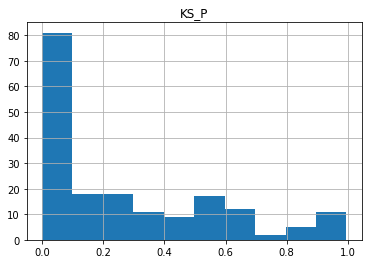

172
(172, 4)


In [75]:
scores = pd.read_csv(file_path+ "/res_signficance_scores.csv")
print(scores.head())
scores.hist("KS_P")
plt.show()
print len(np.where(scores["KS_P"]>1e-6)[0])
res_keep = scores[scores["KS_P"]>1e-6]
print(res_keep.shape)
# interesting how we retain 173 out of 184 with the same cut
# we retain a significantly higher proportion, about 94%

In [76]:
# plot which systems didnt make it
res_rejects = scores[scores["KS_P"]<1e-6]["ID"]
res_rejects_sys = ["Res_sys_{0}_500.csv".format(int(x))  for x in res_rejects]
print res_rejects_sys
# plot_hists(res_rejects_sys)

['Res_sys_143_500.csv', 'Res_sys_165_500.csv', 'Res_sys_166_500.csv', 'Res_sys_304_500.csv', 'Res_sys_334_500.csv', 'Res_sys_34_500.csv', 'Res_sys_347_500.csv', 'Res_sys_366_500.csv', 'Res_sys_49_500.csv', 'Res_sys_60_500.csv', 'Res_sys_89_500.csv', 'Res_sys_95_500.csv']


In [77]:
# look at the worst ones that were kept
# plot which systems didnt make it
res_keep_ordered= res_keep.sort_values("KS_P")
keep_ids = res_keep_ordered["ID"]
res_keep_sys = ["Res_sys_{0}_500.csv".format(int(x))  for x in keep_ids]
print res_keep_sys[:4]
#plot_hists(res_keep_sys[:30])

['Res_sys_99_500.csv', 'Res_sys_36_500.csv', 'Res_sys_243_500.csv', 'Res_sys_188_500.csv']


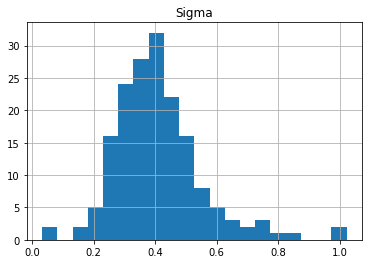

In [78]:
valid_gaus_params= trimmed_info[trimmed_info["ID"].isin((res_keep["ID"]).values)]
valid_gaus_params.hist("Sigma", bins = 20)
plt.show()

Average Sigma 0.4089997069038618 Std in Sigma 0.14447694424385432
('Max valid sigma', 1.0221056312776426)


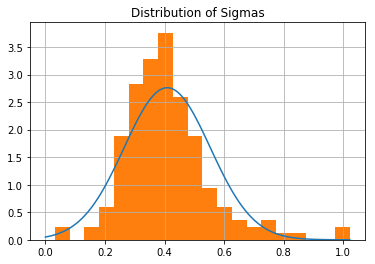

In [79]:
mu_fit, sig_fit =  norm.fit(valid_gaus_params["Sigma"].values)
print "Average Sigma", mu_fit, "Std in Sigma", sig_fit
#x, xmax = plt.xlim()
fig = plt.figure()
ax = fig.add_subplot("111")
x = np.linspace(0, valid_gaus_params["Sigma"].max(), 100)
prob_sig = norm.pdf(x, mu_fit, sig_fit)
plt.plot(x, prob_sig)
valid_gaus_params.hist("Sigma", normed = 1, ax = ax, bins = 20)
print("Max valid sigma", valid_gaus_params["Sigma"].max())
plt.title("Distribution of Sigmas")
plt.show()

(189, 8)
Average Sigma 0.4504391160881758 Std in Sigma 0.1428953452166025


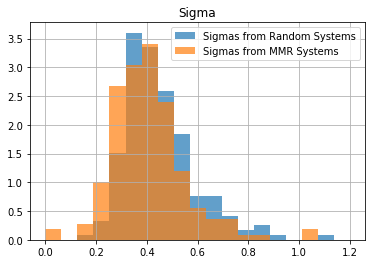

In [80]:
#compare this with the distribution of random systems

random_info_frame = pd.read_csv("../../Figures/MCMCFigures/ProbabilityTable_Fixed_Covariences_266.csv")
random_significances = pd.read_csv("../../csvs/significance_scores.csv")

good_fits = random_significances[random_significances["KS_P"]>1e-6]
random_valid_gaus_params = random_info_frame[ random_info_frame["ID"].isin(good_fits["ID"]) ]
print random_valid_gaus_params.shape

bins = np.linspace(0, 1.2, 20)

rand_mu_fit, rand_sig_fit =  norm.fit(random_valid_gaus_params["Sigma"].values)
print "Average Sigma", rand_mu_fit, "Std in Sigma", rand_sig_fit
#x, xmax = plt.xlim()
fig = plt.figure()
ax = fig.add_subplot("111")
x = np.linspace(0, random_valid_gaus_params["Sigma"].max(), 100)
# rand_prob_sig = norm.pdf(x, rand_mu_fit, rand_sig_fit)
# plt.plot(x, prob_sig)
random_valid_gaus_params.hist("Sigma", normed = 1, ax = ax, bins = bins, label = "Sigmas from Random Systems",alpha = 0.7 )
# overlay plot with resonant sigma parameters
valid_gaus_params.hist("Sigma", normed = 1, ax = ax, bins = bins, label="Sigmas from MMR Systems", alpha = 0.7)
plt.legend()
plt.show()

In [81]:
from scipy.stats import norm
# p is the sigma distribution
# trimmed delta times
print trimmed.shape
#print prob_sig[:10]
#print prob_sig.sum()
norm_prob_sig = prob_sig/(prob_sig.sum())
print norm_prob_sig[-10:]
print x[:10]

(184, 3)
[4.37409223e-05 3.37317889e-05 2.58805251e-05 1.97555473e-05
 1.50033182e-05 1.13362090e-05 8.52178630e-06 6.37346648e-06
 4.74245310e-06 3.51085307e-06]
[0.         0.01089837 0.02179675 0.03269512 0.0435935  0.05449187
 0.06539025 0.07628862 0.087187   0.09808537]


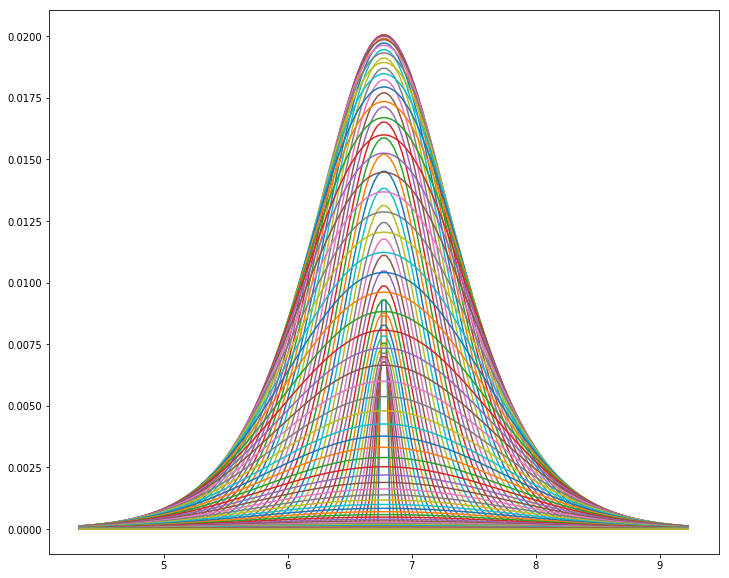

In [82]:
#Analytically over each of the mu;s, how to combine the sigmas?
#try with the first 100
trial = 10 #how many to test it with
max_sigma = mu_fit #the center, used to define bins
increments = 150 # how fine does the convoltion have to be?
#bins = np.linspace(0, 1.5, 20)

plt.figure(figsize=(12, 10))


total_y= np.zeros(increments)
for j in range(1,int(prob_sig.shape[0]), 1):
    fixed_sigma=x[j]
    t_sim = np.log10(trimmed["t"].values[0]) # take the first one
    #print t_sim
    # doesn't matter, the resulting shape will be the same regarless where you do it 
    bins = np.linspace(t_sim -6*max_sigma, t_sim +6*max_sigma, increments)
    final_y = norm.pdf(bins, t_sim, fixed_sigma*2**0.5)* norm_prob_sig[j]       
    total_y +=final_y
    plt.plot(bins, final_y )

end = time.time()
plt.show()


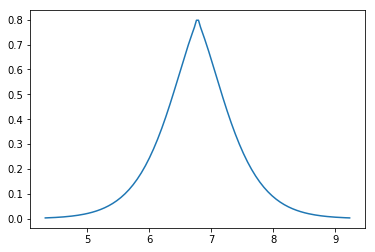

In [83]:
bins = np.linspace(t_sim -6*max_sigma, t_sim +6*max_sigma, increments)
plt.plot(bins, total_y)
width = (12*max_sigma)/(increments-1)
plt.show()
#print  width, bins[1] - bins[0]
#center, spread =laplace.fit(total_y)
#rv =laplace(loc = center, scale = spread)
#loc should be zero, since this should be symmetric about t = 0
# plt.plot(bins, rv.pdf(bins))
# NEed to do a least sqaures fit of a laplaec fit to this data

The laplace distribution has a mean of $\mu$, and a varience of $2b^2$.  P(x) = $\frac{1}{2b}exp(\frac{-|x-\mu|}{b})$

In [84]:
def laplace_fit(data, mean, spread):
    #data is your data
    #mean spread are the params you try to fit to the data
    return np.exp(-np.abs(data-mean)/spread)/2./spread

[6.77428966 0.55525186]
[0.00408788 0.00579842]
('params', array([0.        , 0.55525186]))


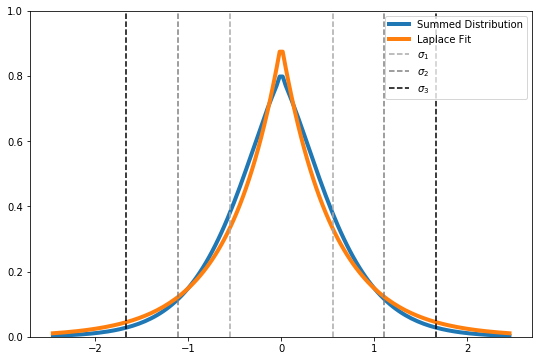

In [85]:
#function for optimizing the difference between total_Y(graph from)
#use the same x values,
plt.figure (figsize=(9, 6))
popt, pcov = curve_fit(laplace_fit, bins, total_y)
print popt
perr = np.sqrt(np.diag(pcov))
print perr

#set popt[0] to 0, since the center should be 0
# center y total as well
bins -= popt[0]
popt[0] = 0

plt.plot(bins, total_y, label = "Summed Distribution", linewidth = 4)
print("params", popt)


plt.plot(bins, laplace_fit(bins, *popt), label = "Laplace Fit", linewidth = 4)
#plt.legend()


colors = ["darkgrey","grey", "black"]
for i in range(1,4):
    plt.axvline(popt[0]+i*popt[1], ls= "dashed", label = "$\sigma_{0}$".format(i), color = colors[i-1])
    plt.axvline(popt[0]-i*popt[1], ls= "dashed", color = colors[i-1])
plt.legend()
plt.ylim([0,1])
plt.show()

need the 10000 data samples before the next part can be done, which is taking all the delta times within our cuts and plotting that distribution


In [86]:
#try testing with the resonant dataset
res_test = pd.read_csv("../../csvs/resonant_data.csv", index_col=0)
res_test.head()

,runstring,seed,pairindex,j,k,Zstar,libfac,Zcom,instability_time,shadow_instability_time
0,0000000.bin,3500000,1,12,1,0.021650,0.007181,0.041669,1.545872e+06,3.063700e+06
1,0000001.bin,700001,1,19,2,0.060291,0.523204,0.010656,9.990000e+08,9.990000e+08
2,0000002.bin,2,0,6,1,0.026353,0.012995,0.050319,9.990000e+08,9.990000e+08
3,0000003.bin,2100003,0,5,2,0.023511,0.713415,0.102200,2.287671e+06,8.392234e+06
4,0000004.bin,700004,0,12,1,0.017473,0.003612,0.039803,9.668931e+05,3.380350e+05


In [87]:
test_samples = res_test[ (np.log10(res_test["instability_time"])<7 ) &
                       (np.log10(res_test["shadow_instability_time"])<7 ) &
                       (np.log10(res_test["instability_time"])>4 ) &
                       (np.log10(res_test["shadow_instability_time"])>4 ) ]


test_samples.shape

(5039, 10)

('Laplacian params', array([0.        , 0.55525186]))
('Mean sig', 0.4089997069038618)


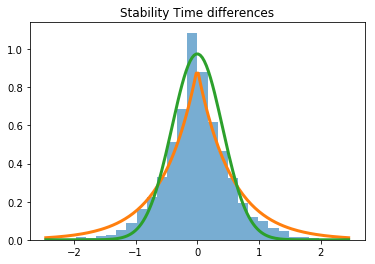

In [88]:
diff_data = np.log10(test_samples["instability_time"]) - np.log10(test_samples["shadow_instability_time"])
plt.hist(diff_data, bins= 30, normed=1, alpha = 0.6)

#plot with laplace fit
plt.plot(bins, laplace_fit(bins, *popt), label = "Laplace Fit", linewidth = 3)
print("Laplacian params", popt[:])

#plot with gaussian with mean width
sig_plot = norm.pdf(bins, 0, mu_fit)
print("Mean sig", mu_fit)
plt.plot(bins, sig_plot, linewidth = 3)
plt.title("Stability Time differences")
plt.show()


In [89]:
# load the differences for random systems
random_test_systems = pd.read_csv("../../csvs/deltatimes.csv", index_col =0)

In [96]:
random_reduced_systems = random_test_systems[(random_test_systems["t"] > 1e4) &
                              (random_test_systems["t"] < 1e7) &
                              (random_test_systems["t_shadow"] > 1e4)
                              & (random_test_systems["t_shadow"]<1e7)]
random_reduced_systems["diff"] = np.log10(random_reduced_systems["t"]) -np.log10(random_reduced_systems["t_shadow"])
#random_reduced_systems = random_reduced_systems.replace([np.inf, -np.inf], np.nan)
#random_reduced_systems = random_reduced_systems.dropna()
print random_reduced_systems.shape
#random_reduced_systems.head()


(4825, 4)


/home/naireen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


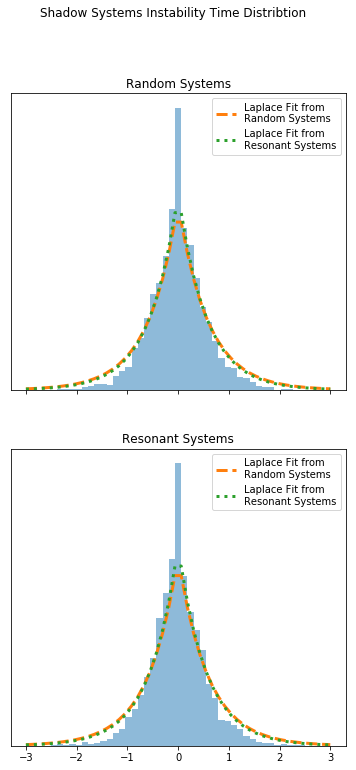

In [159]:
bins = np.linspace(-3,3,50)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6,12))

fig.suptitle("Shadow Systems Instability Time Distribtion")
ax1.hist(random_reduced_systems["diff"].values, bins = bins, normed =1, alpha = 0.5)
ax1.get_yaxis().set_visible(False)
ax1.set_title("Random Systems")

ax2.hist(diff_data, bins = bins, normed =1, alpha = 0.5)
ax2.get_yaxis().set_visible(False)
ax2.set_title("Resonant Systems")

#plot each respective laplace fit for each, as well as the other to compare how similar the fit is
# pull the resonant fit from above
# resonant laplace fit is 0.55525186
# random laplace fit is 0.5899713 -> from MCMC_Analysis/Convolving_Test_New.ipynb

res_laplace = 0.555
rand_laplace = 0.590

ax1.plot(bins, laplace_fit(bins, *[0, rand_laplace]), label = "Laplace Fit from \nRandom Systems", linewidth = 3,  linestyle = "dashed")
ax1.plot(bins, laplace_fit(bins, *[0, res_laplace]), label = "Laplace Fit from \nResonant Systems", linewidth = 3, linestyle = "dotted")

ax2.plot(bins, laplace_fit(bins, *[0, rand_laplace]), label = "Laplace Fit from \nRandom Systems", linewidth = 3, linestyle = "dashed")
ax2.plot(bins, laplace_fit(bins, *[0, res_laplace]), label = "Laplace Fit from \nResonant Systems", linewidth = 3, linestyle = "dotted")


ax1.legend()
ax2.legend()

plt.show()

1) add a KS test of how well the resonant shadow time dist does with the laplacian fit of random systems

2) what is the KS score between the two raw distributions?

In [160]:
ks_2samp(random_reduced_systems["diff"].values, diff_data)

Ks_2sampResult(statistic=0.013605504011713815, pvalue=0.748880073204621)

In [175]:
#generate random laplace dist from random 
rand_laplace_samples = np.random.laplace(0, rand_laplace, 1000)
ks_2samp(rand_laplace_samples, diff_data)

Ks_2sampResult(statistic=0.09527922206787054, pvalue=4.624366965703342e-07)

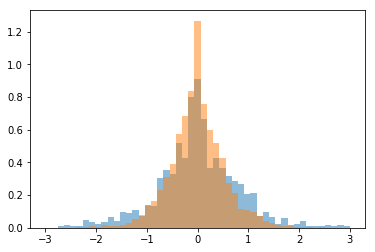

In [176]:
plt.hist(rand_laplace_samples, bins = bins, normed = 1, alpha = 0.5)
plt.hist(diff_data, bins = bins, normed = 1, alpha = 0.5)
plt.show()